# Practical Deep Learning for Coders
## Week 1

Getting started with a simple Neural Network to identify between two image classes

In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *


def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Get an image of a bird

In [2]:
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'http://hdqwalls.com/download/1/colorful-parrot-bird.jpg'

Download the first image and look at it

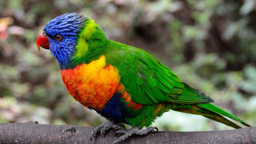

In [3]:
from fastdownload import download_url

dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *

im = Image.open(dest)
im.to_thumb(256, 256)

Do the same for airplanes

Searching for 'airplane photos'


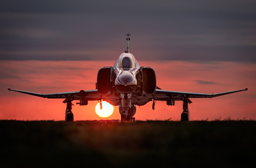

In [4]:
dest = 'airplane.jpg'
download_url(search_images('airplane photos', max_images=1)[0], dest, show_progress=False)
Image.open(dest).to_thumb(256, 256)

Download a couple of the images so that we can use it to train the model

In [5]:
searches = 'airplane', 'bird'
path = Path('bird_or_not')

for o in searches:
    dest = (path / o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(dest, max_size=400, dest=dest)

Searching for 'airplane photo'
Searching for 'bird photo'


Next, remove broken images

In [6]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

Create the data loader class

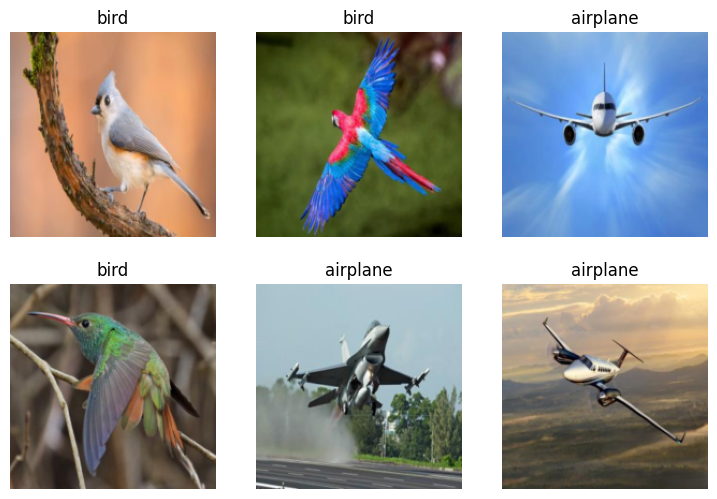

In [7]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Use the resnet18 model.

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/Users/sebastian/Projects/practical-deep-learning/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastian/Projects/practical-deep-learning/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Let's see how it performs.
Here is an image of a bird

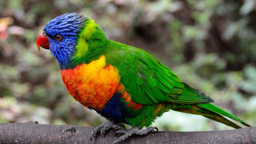

In [9]:
bird_image = PILImage.create('bird.jpg')
bird_image.to_thumb(256, 256)

In [10]:
learn.predict(bird_image)

('bird', TensorBase(1), TensorBase([1.1736e-04, 9.9988e-01]))

In [21]:
is_bird, _, probs = learn.predict(bird_image)
mapping = dict(zip(dls.vocab, map(float, probs)))
mapping

{'airplane': 0.00011735954467440024, 'bird': 0.9998825788497925}

In [24]:
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {mapping[is_bird]:.4f}")

This is a: bird.
Probability it's a bird: 0.9999
